### Load modules

In [1]:
from keras.models import load_model
import keras.backend as K
from keras.layers import *
from keras import Model
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from util import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/henrik/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load data

In [2]:
imgs = np.load('obj/imgs.npy')

def vec2mat(vec, shapes):
    weights = list()
    begin = 0
    for shape in zip(shapes):
        end = begin + shape[0] * shape[1]
        w = vec[begin:end].reshape(shape)
        weights.append(w)
        begin = end
    return weights
    

### Base model

In [3]:
def normalize(x):
    """
    Sum feature wise
    """
    sums = K.sum(K.sum(x, axis=1, keepdims=True), axis=2, keepdims=True)
    return x / sums

def get_base_model():
    model = load_model('obj/darknet_avgpooling.h5')
    xs = [x.output for x in model.layers if type(x) is Conv2D]
    xs = [Lambda(normalize)(x) for x in xs]
    return Model(model.input, xs)
    
def content_loss(x):
    return euclSq(x) / 2

def style_loss(x):
    n, m = map(int, x[0].shape[2:])
    G0 = gram_matrix(x[0])
    G1 = gram_matrix(x[1])
    return euclSq([G0, G1]) / (4 * n**2 * m**2)

### Merged model

In [4]:
def get_merged_model(con, sty, gen, weights):
    base = get_base_model()
    
    con_feat = base(Input(tensor=con))
    sty_feat = base(Input(tensor=sty))
    gen_feat = base(Input(tensor=gen))
    
    con_loss = content_loss([con_feat[3], gen_feat[3]])
    sty_loss = [Lambda(style_loss)([x, y]) for x, y in zip(sty_feat, gen_feat)]
    sty_loss = Add()(sty_loss)
    tot_loss = (con_loss * weights[0] + sty_loss * weights[1]) / (weights[0] + weights[1])
    
    grads = K.gradients([tot_loss], [gen])
    grad_f = K.function([gen], grads)
    loss_f = K.function([gen], [tot_loss])
    
    def calcF(img):
        img = img.reshape(1, 256, 256, 3)
        g = grad_f([img])[0].astype('float64')
        f = loss_f([img])[0]
        return f, g.flatten()
        
    
    return calcF

In [5]:

conImg = imgs[0].reshape(1, 256, 256, 3)
styImg = imgs[110].reshape(1, 256, 256, 3)
genImg0 = conImg + 0.1 * np.random.randn(*conImg.shape)

content = tf.Variable(conImg)
style = tf.Variable(styImg)
generated = tf.placeholder(np.float32, (None, 256, 256, 3))

calcF1 = get_merged_model(content, style, generated, (1, 1))
genOpt1, _, _ = fmin_l_bfgs_b(calcF1, genImg0, disp=1, maxiter=25)

genImg1 = genOpt1.reshape(256, 256, 3)

/home/henrik/miniconda3/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


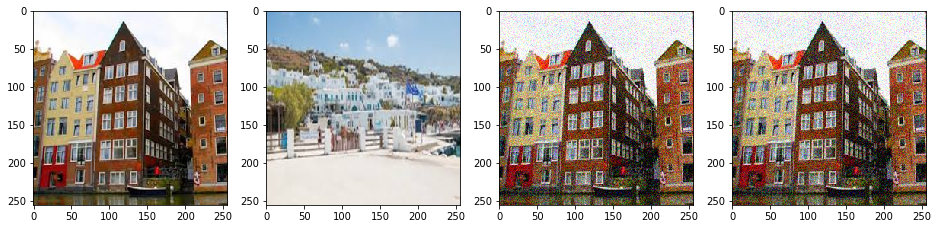

In [8]:
plt.figure(figsize=(16,8))
plt.subplot(1,4,1)
plt.imshow(conImg[0])
plt.subplot(1,4,2)
plt.imshow(styImg[0])
plt.subplot(1,4,3)
plt.imshow(genImg0[0])
plt.subplot(1,4,4)
plt.imshow(genImg1)